# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(-0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

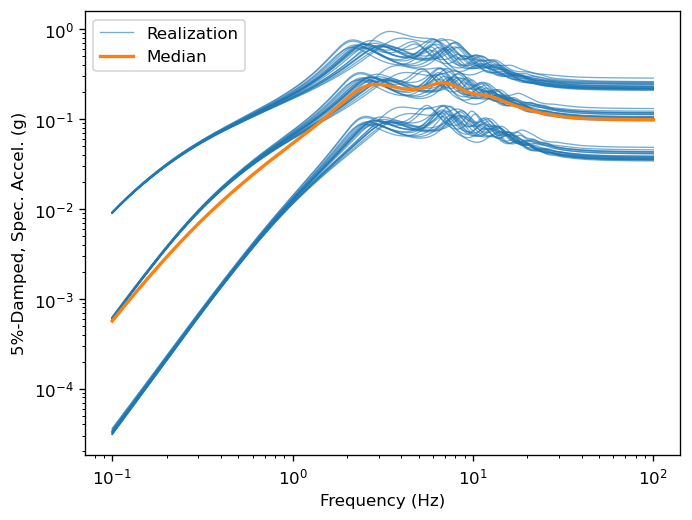

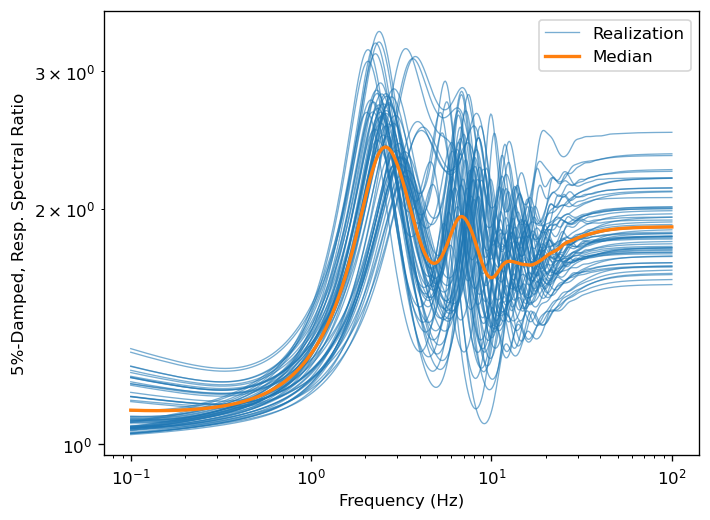

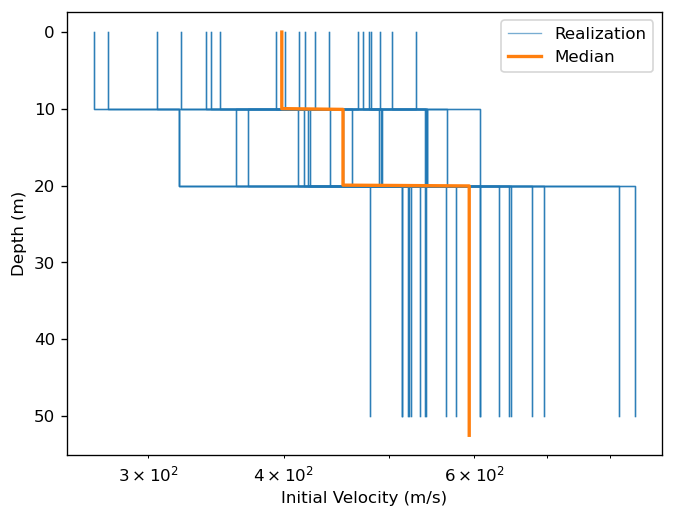

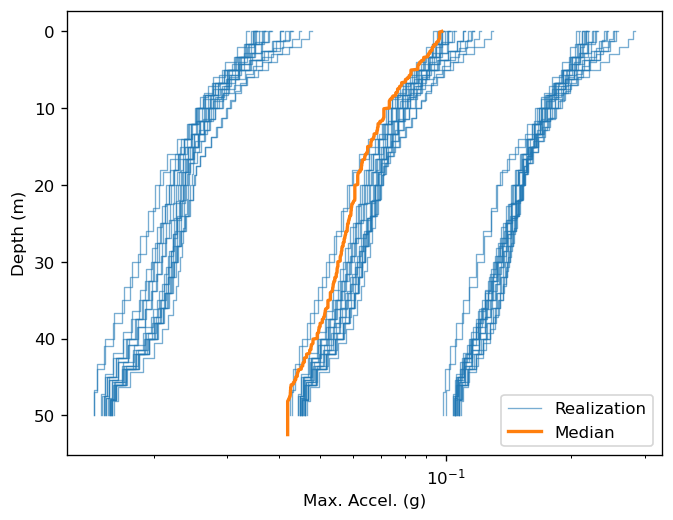

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [22]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.215350  1.072268  1.045172  1.257490  1.084067  1.051905   
0.101394    1.214595  1.072211  1.045520  1.256489  1.083987  1.052300   
0.102807    1.213841  1.072159  1.045872  1.255491  1.083913  1.052699   
0.104240    1.213091  1.072112  1.046227  1.254497  1.083844  1.053103   
0.105693    1.212344  1.072071  1.046586  1.253507  1.083782  1.053511   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.001332  1.908201  1.781819  1.899096  1.814966  1.652008   
95.932095   2.001404  1.908270  1.781909  1.899177  1.815052  1.652112   
97.269336   2.001473  1.908337  1.781995  1.899256  1.815136  1.652212   
98.625218   2.001541  1.908401  1.782079  1.899332  1.815217  1.652310   
100.000000  2.001606  1.908464  1.782160  1.899406  1.815295  1.652405   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.215140  1.072405  1.045665  1.163660  ...  1.031057  1.323789   
0.101394    1.214380  1.072347  1.046016  1.163141  ...  1.031305  1.322525   
0.102807    1.213622  1.072294  1.046371  1.162624  ...  1.031555  1.321265   
0.104240    1.212868  1.072246  1.046730  1.162108  ...  1.031808  1.320009   
0.105693    1.212116  1.072204  1.047092  1.161595  ...  1.032064  1.318757   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.842222  1.780699  1.667670  1.865070  ...  1.683626  2.350291   
95.932095   1.842316  1.780789  1.667778  1.865124  ...  1.683674  2.350409   
97.269336   1.842408  1.780876  1.667883  1.865177  ...  1.683720  2.350523   
98.625218   1.842496  1.780960  1.667984  1.865228  ...  1.683765  2.350633   
100.000000  1.842582  1.781042  1.668083  1.865277  ...  1.683808  2.350740   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.105738  1.067666  1.193587  1.069658  1.046319  1.200554   
0.101394    1.105623  1.068161  1.193044  1.069612  1.046675  1.199836   
0.102807    1.105515  1.068661  1.192503  1.069571  1.047034  1.199120   
0.104240    1.105413  1.069166  1.191964  1.069534  1.047397  1.198407   
0.105693    1.105318  1.069676  1.191427  1.069503  1.047763  1.197697   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.186689  1.949217  2.504072  2.338466  2.187343  1.802743   
95.932095   2.186816  1.949373  2.504139  2.338531  2.187456  1.802808   
97.269336   2.186938  1.949523  2.504204  2.338593  2.187566  1.802871   
98.625218   2.187057  1.949670  2.504266  2.338654  2.187673  1.802932   
100.000000  2.187172  1.949812  2.504327  2.338713  2.187776  1.802991   

                                
                  m1        m2  
0.100000    1.066905  1.041275  
0.101394    1.066854  1.041596  
0.102807    1.066808  1.041921  
0.104240    1.066767  1.042249  
0.105693    1.066732  1.042580  
...              ...       ...  
94.613238   1.736468  1.622369  
95.932095   1.736532  1.622448  
97.269336   1.736593  1.622524  
98.625218   1.736653  1.622598  
100.000000  1.736710  1.622670  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [23]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.215350
0.101394,p0,m0,1.214595
0.102807,p0,m0,1.213841
0.104240,p0,m0,1.213091
0.105693,p0,m0,1.212344
...,...,...,...
94.613238,p19,m2,1.622369
95.932095,p19,m2,1.622448
97.269336,p19,m2,1.622524


In [24]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.206309  0.042851
           m1      1.069436  0.015266
           m2      1.043542  0.010190
0.101394   m0      1.205598  0.042672
           m1      1.069383  0.015242
...                     ...       ...
98.625218  m1      1.906417  0.085518
           m2      1.781580  0.080672
100.000000 m0      2.003450  0.095675
           m1      1.906475  0.085520
           m2      1.781657  0.080673

[1500 rows x 2 columns]

In [25]:
stats = (
    stats.reset_index("motion").pivot(columns="motion").swaplevel(0, 1, axis=1).sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.042851  1.206309  0.015266  1.069436  0.010190  1.043542
0.101394    0.042672  1.205598  0.015242  1.069383  0.010256  1.043877
0.102807    0.042494  1.204890  0.015218  1.069334  0.010323  1.044216
0.104240    0.042315  1.204184  0.015196  1.069290  0.010391  1.044558
0.105693    0.042138  1.203481  0.015174  1.069252  0.010459  1.044903
...              ...       ...       ...       ...       ...       ...
94.613238   0.095673  2.003197  0.085513  1.906232  0.080668  1.781334
95.932095   0.095673  2.003263  0.085515  1.906296  0.080669  1.781418
97.269336   0.095674  2.003328  0.085517  1.906358  0.080671  1.781501
98.625218   0.095674  2.003390  0.085518  1.906417  0.080672  1.781580
100.000000  0.095675  2.003450  0.085520  1.906475  0.080673  1.781657

[500 rows x 6 columns]

Access the properties of each motion like:

In [26]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.042851,1.206309
0.101394,0.042672,1.205598
0.102807,0.042494,1.204890
0.104240,0.042315,1.204184
0.105693,0.042138,1.203481
...,...,...
94.613238,0.095673,2.003197
95.932095,0.095673,2.003263
97.269336,0.095674,2.003328


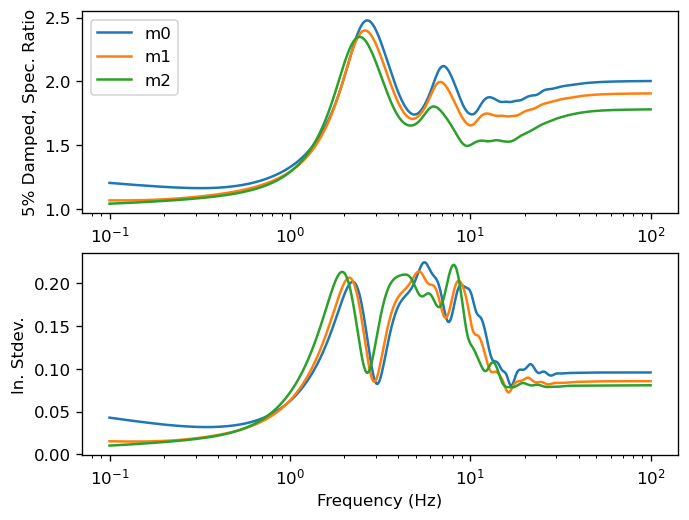

In [44]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;